# College Football Simulation with New Pairing System
### By Rodrigo Vargas and Daniel Yedidia
Project for PIC-16B Python with Applications II, UCLA Spring 2023 <br>
Github: https://github.com/dyeds/PIC-16B-Project

(Delete from final report)

Structure: (Tentative)  

1. Information & Credits: CollegeFootballData.com, https://www.reddit.com/r/CFB/comments/qq553i/what_would_college_football_look_like_under_a/ Post by u/dethwing_.
2. Explanation of the project and how to use the notebook
3. Data Acquisition and Preprocessing. Working with CFBD and BingMaps API's and storing locally on Database
4. Model creation using Tensorflow. Creating various models and motives on why to use Betting Lines.
5. Explanation and Implementation of Minimum Weight Matching Algorithm using Networkx for pairings and using distances.
6. SQL Database with Simulated Games and other table creating Functions.
7. Visualizations of Simulation using Plotly.
8. Biases and Future Improvements for the project. 

## Credits

This project was done with the help of https://collegefootballdata.com to obtain college football data, and inspired by reddit user: u/dethwing_ post https://www.reddit.com/r/CFB/comments/qq553i/what_would_college_football_look_like_under_a/ 

## Project Overview and Instructions

The objective of this project is to: Simulate a College Football Division 1 FBS Season, using a Swiss-like Pairing System that uses teams' record and proximity of teams' locations as pairing factors. Technical components include using `SQLite3` to store and merge various dataframes as needed, machine learning on `tensorflow` to predict individual games, various API's and tools like `networkx` to do the pairings, and `plotly` for visualizations.

The purpose of the model is not to predict upcoming college football games, rather to simulate a scoreline for a game played by any two FBS teams between 2015-2022, so as a whole our model simulates a recreation of one of these seasons. To create the model, we acquire a bunch of data from various API's at https://collegefootballdata.com, including all the D1 FBS games played between 2015-2022, overall team season statistics for each of those years to use as predictor variables, and betting lines for those games to use as target variables. 

Then, we also get the geographic coordinates of all these teams' locations, and using the Bing Maps API obtain the driving distance between every pair of teams, which we'll use as a measure of how close by other teams are. Finally we use this data to pair the teams simulate each week's games with our model, which gives us an entire simulated season under the new pairing conditions.

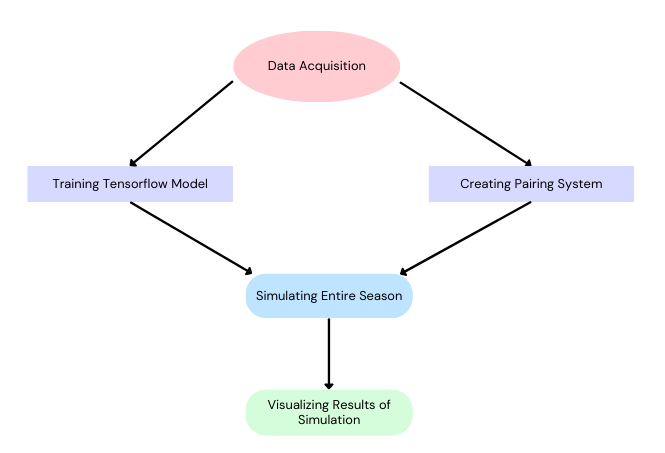

This notebook includes all the code needed to run the simulation from start to end, including a more detailed explanation of the code and information needed. It was developed using `Python 3.9`, but any version 3.6+ should work.

There is a pre-existing tensorflow machine learning model and a SQL database with all the data needed, including an example simulated season in the GitHub. Therefore it is not required to run the code cells that involve API calls or Simulating a season if there is any computational or time limitations. Feel free to explore the example simulation by openning `CollegeFootball.db` on any suitable file reader. If you do want to run your own instance of the simulation, you can follow along in the code below. Otherwise, you can focus on the output and discussion of the results from each step rather than the code itself.

Firstly, below we have all the imports used for the whole project, in order of how they appear on this document. The first one, `DataFunctions`, imports all the functions created to simplify some processes, which can be found in the GitHub.

In [1]:
#List of Imports here:
import DataFunctions
import cfbd
from cfbd.rest import ApiException
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import networkx as nx


## Data Acquisition and Preprocessing

As explained before, we need College Football Data and Locations Data for the simulation, which will be obtained using CFBD and BingMaps API's. They typically require registering and getting an unique key, this is done to keep track of who and how many API calls are needed. Some API's may ask you to pay after certain number of calls, but for this project is not needed.

College football data is needed for all the simulation purposes, extracting all FBS teams and their season stats. First install using command: `"pip install cfbd"`. Then register on https://collegefootballdata.com/key to obtain a key and create a configuration object with that data, and then we will be able to use the API.

In [2]:
# import cfbd
# from cfbd.rest import ApiException

configuration = cfbd.Configuration()
# configuration.api_key['Authorization'] = 'YOUR_KEY_HERE'
configuration.api_key['Authorization'] = '3WCU5V2X05Rvh60ZxUG8FarJN4s2D1lcd2c2r6Kz/qL1Y3tVBJtWsuNATnzHRV2h'
configuration.api_key_prefix['Authorization'] = 'Bearer'

Now we have to extract data from 3 classes: `GamesApi` which gives us data for all the games; `BettingApi` which gives us data for all the betting lines; and `StatsApi` which gives us the team season data.

In our predictive modeling, we are going to use a merge between game data and team data as our predictor variables, and betting lines data as our target variables. Below is an example for data extraction, though the actual process was performed with functions inside `DataFunctions.py` file. 

In [3]:
api_instance = cfbd.GamesApi(cfbd.ApiClient(configuration))
year=2022
division="fbs"

try:
    api_response = api_instance.get_games(year=year,division=division)
    print(len(api_response))
except:
    print(ApiException)

858


Before creating tables in our SQL database, we have to create instances for each sub-API. Also needed is a list of conferences of all the D1 FBS teams, which we can get from the `games` data, so that we only extract the betting lines for the teams that we want when calling the `BettingApi`. Then we get the relevant data from the API's, where each function which calls the API returns a dataframe (see documentation for further detail) which we then add as and SQL table to our database.

In [4]:
# import sqlite3
# import pandas as pd

# Creating API Instances:
api_instance = cfbd.GamesApi(cfbd.ApiClient(configuration))
api_instance1 = cfbd.BettingApi(cfbd.ApiClient(configuration))
api_instance2 = cfbd.StatsApi(cfbd.ApiClient(configuration))

#creating cols to work on selected stats data
cols = ['team','season','conference','Offensive_ppa','Offensive_success_rate',
        'Offensive_explosiveness','Offensive_power_success',
        'Offensive_stuff_rate','Offensive_line_yards',
        'Defensive_ppa','Defensive_success_rate',
        'Defensive_explosiveness','Defensive_power_success',
        'Defensive_stuff_rate','Defensive_line_yards',
        'Offensive_havoc_total','Offensive_rushing_plays_ppa',
        'Offensive_rushing_plays_success_rate',
        'Offensive_rushing_plays_explosiveness',
        'Offensive_passing_plays_ppa',
        'Offensive_passing_plays_success_rate',
        'Offensive_passing_plays_explosiveness',
        'Defensive_havoc_total','Defensive_rushing_plays_ppa',
        'Defensive_rushing_plays_success_rate',
        'Defensive_rushing_plays_explosiveness',
        'Defensive_passing_plays_ppa',
        'Defensive_passing_plays_success_rate',
        'Defensive_passing_plays_explosiveness']

#creating conferences to obtain data from them:
gamelist = DataFunctions.get_fbs_games(api_instance=api_instance,year=year)
conferences=[]
for game in gamelist:
        conferences.append(game.away_conference)
conferences=set(conferences)

games_df = DataFunctions.df_from_games(gamelist=gamelist)
betting_list=DataFunctions.get_fbs_betting(api_instance=api_instance1,year=2022,conferences=conferences)
betting_df=DataFunctions.df_betting_lines(betting_list)


# for year in range(2015,2023):
#     #obtaining games data
#     gamelist = DataFunctions.get_fbs_games(api_instance=api_instance,year=year)
#     games_df = DataFunctions.df_from_games(gamelist=gamelist)
    
#     #creating conferences to obtain data from them:
#     conferences=[]
#     for game in gamelist:
#         conferences.append(game.away_conference)
#     conferences=set(conferences)
    
#     #obtaining betting data
#     betting_list=DataFunctions.get_fbs_betting(api_instance=api_instance1,year=year,conferences=conferences)
#     betting_df=DataFunctions.df_betting_lines(betting_list)
    
#     #obtaining stats data
#     teamstats = api_instance2.get_advanced_team_season_stats(year=year)
#     stats_df = DataFunctions.df_team_advstats(teamstats=teamstats)
#     stats_df = DataFunctions.df_stats_needed(stats_df,cols)
    
#     #inserting all dataframes into sql databases.
#     conn = sqlite3.connect("CollegeFootball.db")
#     games_df.to_sql("games",conn,if_exists="append",index=False)
#     betting_df.to_sql("betting_lines",conn,if_exists="append",index=False)
#     stats_df.to_sql("stats",conn,if_exists="append",index=False)
    
#     conn.close()

At this point we have obtained all the games and statistics needed from the relevant teams for our model. Modifications can be made to consider FCS teams or other years' worth of data. 

The other data we have to collect is the distances between all the teams in our simulation, as we want our pairing system to minimize the distance each team has to travel while playing teams with the same record as them. First, we extract the geographic coordinates of every team using the `TeamsApi` from the college football data site.

In [5]:
api_instance3 = cfbd.TeamsApi(cfbd.ApiClient(configuration))
team_locations=DataFunctions.get_team_locations(api_instance3,conferences)

For the purposes of our simulation, we want an even number of total teams, and it turns out few of the teams joined the FBS division quite recently and thus did not have statistics from all the years of data we collected. Thus we decided to drop the following teams from the simulation, which cut us down from 133 teams to 126 teams total. We also store this data table in our SQL dataabse.

In [6]:
team_locations=team_locations[team_locations.team != "Hawai'i"]
team_locations=team_locations[team_locations.team != "Jacksonville State"]
team_locations=team_locations[team_locations.team != "Sam Houston State"]
team_locations=team_locations[team_locations.team != "James Madison"]
team_locations=team_locations[team_locations.team != "Liberty"]
team_locations=team_locations[team_locations.team != "Coastal Carolina"]
team_locations=team_locations[team_locations.team != "Charlotte"]
team_locations=team_locations.reset_index(drop=True)
team_locations

,team,id,latitude,longitude
0,Air Force,2005,38.996970,-104.843616
1,Akron,2006,41.072553,-81.508341
2,Alabama,333,33.208275,-87.550384
3,Appalachian State,2026,36.211427,-81.685428
4,Arizona,12,32.228805,-110.948868
...,...,...,...,...
121,Western Kentucky,98,36.984790,-86.459404
122,Western Michigan,2711,42.286006,-85.600757
123,West Virginia,277,39.650274,-79.955187
124,Wisconsin,275,43.069940,-89.412694


In [7]:
conn = sqlite3.connect("CollegeFootball.db")
team_locations.to_sql("coordinates",conn,if_exists="replace",index=False)

conn.close()

Now in order to measure the proximity of different teams, we will use the driving distances between every two teams (in hr), which we can collect from the Bing Maps API. We first create an 126 by 126 symmetric matrix in the form of an array, where the {ij}th entry is the distance between team i and team j, where the teams are encoded by their index in the `team_locations` table. Then we convert this table to a dataframe, and store it in our SQL database. (We recommend you obtain this table via our database instead of running it yourself, as it takes about 40 minutes to make the ~8000 API calls)

In [8]:
# distances_array=np.zeros((len(team_locations),len(team_locations)))

# for i in range(distances_array.shape[0]):
#     latitude_i=team_locations['latitude'][i]
#     longitude_i=team_locations['longitude'][i]
#     for j in range(i+1,distances_array.shape[0]):
#         latitude_j=team_locations['latitude'][j]
#         longitude_j=team_locations['longitude'][j]
#         url=f'http://dev.virtualearth.net/REST/V1/Routes?wp.0={latitude_i},{longitude_i}&wp.1={latitude_j},{longitude_j}&key=Aqi_rLZG4IuK6xhv3afUnfG36m98qTOEywzz5hDkbWM2rs8zA7FKGP3h8Zjm5SU7'
#         request = urllib.request.Request(url)
#         response = urllib.request.urlopen(request)
#         r = response.read().decode(encoding="utf-8")
#         result = json.loads(r)
#         distances_array[i,j]= result['resourceSets'][0]['resources'][0]['travelDuration']
#         distances_array[i,j]=distances_array[i,j]/3600  #convert from sec to hr
#         distances_array[j,i]= distances_array[i,j]


# distances_df=pd.DataFrame(distances_array)

# conn = sqlite3.connect("CollegeFootball.db")
# distances_df.to_sql("distances",conn,if_exists="replace",index=False)

# conn.close()

In [9]:
conn = sqlite3.connect("CollegeFootball.db")
distances = pd.read_sql_query("SELECT * FROM distances",conn)

conn.close()

distances

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,0.000000,18.768889,18.059167,20.645556,11.290556,11.266389,10.980278,14.000833,25.148056,19.765278,...,21.718333,20.450556,21.376944,18.996389,16.578333,15.363333,15.908333,19.993056,13.922500,2.934167
1,18.768889,0.000000,10.334722,6.569444,27.659722,27.704444,12.506944,10.238056,6.508333,11.017500,...,6.343056,5.205278,6.131667,32.907500,30.186667,6.253889,4.042500,2.715278,7.173333,18.486944
2,18.059167,10.334722,0.000000,7.064444,20.666111,22.140278,7.771944,4.552778,14.962778,2.671944,...,9.436944,7.641667,7.374722,35.676389,32.955556,4.376111,10.627778,10.523889,11.779722,19.784722
3,20.645556,6.569444,7.064444,0.000000,26.890000,27.649722,12.239722,9.020556,9.865833,6.243611,...,4.340000,2.544722,1.598333,37.889167,35.168333,6.050278,10.140556,5.426944,12.155278,22.007222
4,11.290556,27.659722,20.666111,26.890000,0.000000,1.684167,16.571944,18.985278,34.053333,22.713611,...,29.253611,27.458056,27.738333,22.165833,20.551389,22.686389,25.758889,28.898056,24.628611,14.070278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,15.363333,6.253889,4.376111,6.050278,22.686389,23.459167,8.083611,4.830833,12.638611,5.548889,...,8.145278,6.628056,7.132500,32.585278,29.856667,0.000000,6.535833,6.921389,7.766944,16.734167
122,15.908333,4.042500,10.627778,10.140556,25.758889,25.787222,10.596944,8.707222,10.226389,11.800556,...,9.882500,8.753333,9.701667,29.808056,27.079444,6.535833,0.000000,6.359722,4.155556,15.425833
123,19.993056,2.715278,10.523889,5.426944,28.898056,28.926389,13.736111,10.941667,6.153056,10.535833,...,4.085278,4.039722,4.988056,35.175278,32.446667,6.921389,6.359722,0.000000,9.524722,20.838056
124,13.922500,7.173333,11.779722,12.155278,24.628611,24.656667,9.873611,8.546667,13.357222,12.952500,...,12.521111,11.237778,12.186111,26.112500,23.383889,7.766944,4.155556,9.524722,0.000000,13.431389


Lastly, we need to preprocess some of the data to be able to create models with it. The main idea is to have our predictors be a combination of games and teams data, therefore we need to create a dataframe which correctly retrieves data considering game results, home team season statistics and away team season statistics. To do this, we use SQL merge queries where we do an "inner join" on the columns that appear in both dataframes we're trying to merge, such as the 'game id' of each game played. By using an "inner join" we ensure that all our data has all the necessary parts, for example when we're merging the game results with the betting lines, if there is a game with no corresponding betting lines recorded or a betting line with no matching game found, these rows get dropped from the dataframe. 

Before we actually merge the data tables, the code below helps the SQL query obtain the proper columns and sets up their proper labels. As we are obtaining two rows of data from the stats table to input in the model, corresponding to the two teams facing each other, we need to properly rename the columns to differentiate between the home team and away statistics.

In [10]:
gcols = games_df.columns
gstr = ""
for c in gcols:
    gstr += "G."+str(c)+","
bcols = betting_df.columns
bstr = ""
for b in bcols:
    bstr += "B."+str(b)+","
bstr = bstr[5:]
s1 = ""
for c in cols:
   s1 += "S1." + str(c) +  " AS Home_" + str(c) + ", "
s1 = s1[:-1]
s2 = ""
for c in cols:
   s2 += "S2." + str(c) +  " AS Away_" + str(c) + ", "
s2 = s2[:-2]

In [11]:
cmd=\
f"""
SELECT {str(gstr)} {str(bstr)} {str(s1)} {str(s2)}
FROM games G
INNER JOIN betting_lines B ON G.id=B.id
INNER JOIN stats S1 ON S1.team=G.home_team
INNER JOIN stats S2 ON S2.team=G.away_team
WHERE (S2.season=G.season AND S1.season=G.season)
"""

conn=sqlite3.connect("CollegeFootball.db")
df_merged=pd.read_sql_query(cmd,conn)
conn.close() 

After the merge we have the following merged dataframe.

In [12]:
df_merged.head()

,id,season,neutral_site,home_id,home_team,home_conference,home_points,away_id,away_team,away_conference,...,Away_Offensive_passing_plays_ppa,Away_Offensive_passing_plays_success_rate,Away_Offensive_passing_plays_explosiveness,Away_Defensive_havoc_total,Away_Defensive_rushing_plays_ppa,Away_Defensive_rushing_plays_success_rate,Away_Defensive_rushing_plays_explosiveness,Away_Defensive_passing_plays_ppa,Away_Defensive_passing_plays_success_rate,Away_Defensive_passing_plays_explosiveness
0,400603840,2015,1,2579,South Carolina,SEC,17,153,North Carolina,ACC,...,0.424908,0.470449,1.739379,0.015260,0.247354,0.499230,0.956353,0.120597,0.407489,1.455767
1,400763593,2015,0,2116,UCF,American Athletic,14,2229,Florida International,Conference USA,...,0.153434,0.410798,1.476512,0.011222,0.170103,0.490654,0.939800,0.157446,0.445055,1.305146
2,400763399,2015,0,2117,Central Michigan,Mid-American,13,197,Oklahoma State,Big 12,...,0.431469,0.465201,1.796764,0.016848,0.168124,0.439163,0.997732,0.178258,0.384615,1.672654
3,400603839,2015,0,238,Vanderbilt,SEC,12,98,Western Kentucky,Conference USA,...,0.516965,0.515712,1.614563,0.018162,0.140229,0.416667,1.069274,0.251573,0.395197,1.781922
4,400756883,2015,0,254,Utah,Pac-12,24,130,Michigan,Big Ten,...,0.314188,0.454965,1.551991,0.011990,0.074741,0.338272,1.188341,-0.040890,0.306763,1.524436


We proceed to drop some columns to create our predictors dataframe and our target dataframe using betting lines as the target variable, specifically the spread and the over-under.

In [13]:
#predictors df
parameters_df=df_merged.drop(['id','season', 'home_id', 'home_team',
       'home_conference', 'home_points', 'away_id', 'away_team',
       'away_conference', 'away_points', 'game_spread', 'game_totalpts',
       'av_spread', 'av_total','Home_team','Away_team','Home_conference','Away_conference',
       'Home_season','Away_season'], axis=1)

In [14]:
parameters_df.columns

Index(['neutral_site', 'Home_Offensive_ppa', 'Home_Offensive_success_rate',
       'Home_Offensive_explosiveness', 'Home_Offensive_power_success',
       'Home_Offensive_stuff_rate', 'Home_Offensive_line_yards',
       'Home_Defensive_ppa', 'Home_Defensive_success_rate',
       'Home_Defensive_explosiveness', 'Home_Defensive_power_success',
       'Home_Defensive_stuff_rate', 'Home_Defensive_line_yards',
       'Home_Offensive_havoc_total', 'Home_Offensive_rushing_plays_ppa',
       'Home_Offensive_rushing_plays_success_rate',
       'Home_Offensive_rushing_plays_explosiveness',
       'Home_Offensive_passing_plays_ppa',
       'Home_Offensive_passing_plays_success_rate',
       'Home_Offensive_passing_plays_explosiveness',
       'Home_Defensive_havoc_total', 'Home_Defensive_rushing_plays_ppa',
       'Home_Defensive_rushing_plays_success_rate',
       'Home_Defensive_rushing_plays_explosiveness',
       'Home_Defensive_passing_plays_ppa',
       'Home_Defensive_passing_plays_success_

In [15]:
parameters_df

,neutral_site,Home_Offensive_ppa,Home_Offensive_success_rate,Home_Offensive_explosiveness,Home_Offensive_power_success,Home_Offensive_stuff_rate,Home_Offensive_line_yards,Home_Defensive_ppa,Home_Defensive_success_rate,Home_Defensive_explosiveness,...,Away_Offensive_passing_plays_ppa,Away_Offensive_passing_plays_success_rate,Away_Offensive_passing_plays_explosiveness,Away_Defensive_havoc_total,Away_Defensive_rushing_plays_ppa,Away_Defensive_rushing_plays_success_rate,Away_Defensive_rushing_plays_explosiveness,Away_Defensive_passing_plays_ppa,Away_Defensive_passing_plays_success_rate,Away_Defensive_passing_plays_explosiveness
0,1,0.135110,0.398230,1.310823,0.537037,0.240602,2.786466,0.245734,0.469222,1.193992,...,0.424908,0.470449,1.739379,0.015260,0.247354,0.499230,0.956353,0.120597,0.407489,1.455767
1,0,-0.030181,0.359949,1.089648,0.718750,0.245509,2.368563,0.274816,0.447399,1.370219,...,0.153434,0.410798,1.476512,0.011222,0.170103,0.490654,0.939800,0.157446,0.445055,1.305146
2,0,0.168963,0.426384,1.243901,0.690476,0.264205,2.378693,0.123896,0.401535,1.143104,...,0.431469,0.465201,1.796764,0.016848,0.168124,0.439163,0.997732,0.178258,0.384615,1.672654
3,0,0.007890,0.369738,1.126528,0.567164,0.236052,2.593562,0.046162,0.379227,1.123273,...,0.516965,0.515712,1.614563,0.018162,0.140229,0.416667,1.069274,0.251573,0.395197,1.781922
4,0,0.139662,0.438034,1.087708,0.780488,0.194085,2.946211,0.064989,0.403226,1.273348,...,0.314188,0.454965,1.551991,0.011990,0.074741,0.338272,1.188341,-0.040890,0.306763,1.524436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5583,1,0.382290,0.531523,1.227645,0.702128,0.174157,3.242884,0.033671,0.352811,1.222969,...,0.289789,0.480916,1.435500,0.148707,0.131838,0.424051,0.964949,0.125653,0.361233,1.690313
5584,0,0.222084,0.422553,1.238781,0.770833,0.136069,3.271922,0.068274,0.340659,1.264380,...,0.362215,0.479508,1.376398,0.182018,0.131782,0.407489,1.035572,0.163956,0.373333,1.559630
5585,1,0.295542,0.461914,1.338389,0.712329,0.164502,3.167316,0.269587,0.477000,1.196434,...,0.203810,0.413174,1.464382,0.210043,0.042026,0.386935,0.899329,0.081042,0.372624,1.523842
5586,1,0.297575,0.503619,1.214274,0.775281,0.156089,3.239966,0.031886,0.363014,1.176733,...,0.227180,0.426168,1.414203,0.164634,0.107320,0.410758,0.930402,0.245988,0.402500,1.651034


In [16]:
#target df
predict_betting_df=df_merged[['av_spread','av_total','id']]
predict_betting_df

,av_spread,av_total,id
0,2.000000,62.00,400603840
1,12.666667,44.25,400763593
2,-20.833333,57.75,400763399
3,4.333333,60.00,400603839
4,4.333333,44.75,400756883
...,...,...,...
5583,17.125000,51.75,401437036
5584,3.000000,54.75,401437034
5585,-7.250000,64.00,401437009
5586,15.625000,53.75,401437031


Finally we have the necessary dataframes to begin working on our model.

## Predictive Model using Tensorflow

We arrays to use on tensorflow and create our first predictive model, which uses betting lines as predictors. Using a train_test split of 70% train and 30% test data.

In [17]:
# import numpy as np
# from sklearn.model_selection import train_test_split

df = pd.DataFrame()
X = np.array(parameters_df,dtype=np.float32)
y_betting = np.array(predict_betting_df)    #predicting betting info

X_train, X_test, y_train, y_test = train_test_split(X,y_betting,test_size=0.3)

We now create a simple 2 layer neural network using tensorflow. We use the Sequential model, which simply allows us to create a model layer by layer. We compile the model using 'adam' optimizer, an efficient variation of Gradient Descent, and using 'mse' Mean Squared Error as the loss function to minimize. 

In [18]:
model = tf.keras.models.Sequential([
    layers.Dense(100,input_shape=(X_train.shape[1],),activation='relu'),
    layers.Dense(100,activation='relu'),
    layers.Dense(2)
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae','mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5400      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 15,702
Trainable params: 15,702
Non-trainable params: 0
_________________________________________________________________


We proceed to train our model for 100 epochs, which should be enough to fit the model. After that we can display the performance of the model by plotting the error function progress and the results for various spreads.

In [19]:
history = model.fit(X_train,y_train[:,:2],epochs=100,verbose=1)

Epoch 1/100
 46/123 [==========>...................] - ETA: 0s - loss: 1177.7145 - mae: 28.1014 - mse: 1177.7145 123/123 [==============================] - 1s 1ms/step - loss: 533.2246 - mae: 16.3216 - mse: 533.2246
Epoch 2/100
123/123 [==============================] - 0s 1ms/step - loss: 127.1897 - mae: 8.5594 - mse: 127.1897
Epoch 3/100
123/123 [==============================] - 0s 1ms/step - loss: 119.5666 - mae: 8.3305 - mse: 119.5666
Epoch 4/100
123/123 [==============================] - 0s 1ms/step - loss: 104.3034 - mae: 7.8458 - mse: 104.3034
Epoch 5/100
123/123 [==============================] - 0s 1ms/step - loss: 80.2785 - mae: 6.9941 - mse: 80.2785
Epoch 6/100
123/123 [==============================] - 0s 1ms/step - loss: 64.0957 - mae: 6.2522 - mse: 64.0957
Epoch 7/100
123/123 [==============================] - 0s 1ms/step - loss: 61.3391 - mae: 6.0973 - mse: 61.3391
Epoch 8/100
123/123 [==============================] - 0s 1ms/step - loss: 60.6437 - mae: 6.0439 - mse: 60

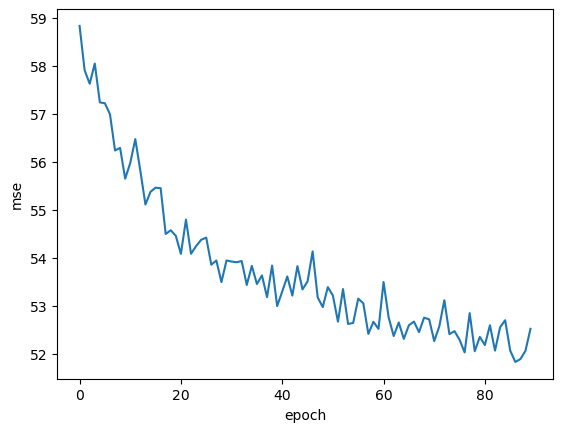

In [20]:
# from matplotlib import pyplot as plt
plt.plot(history.history["mse"][10:])
plt.gca().set(xlabel="epoch",ylabel="mse")
plt.show()

In [21]:
#evaluating on test data
model.evaluate(X_test,y_test[:,:2],verbose=2)

53/53 - 0s - loss: 53.2261 - mae: 5.5488 - mse: 53.2261 - 159ms/epoch - 3ms/step


[53.226070404052734, 5.548757553100586, 53.226070404052734]

In [22]:
predictions = model.predict(X_test)

53/53 [==============================] - 0s 767us/step


In [23]:
predictions,y_test

(array([[  9.411581 ,  47.136482 ],
        [ 15.514559 ,  48.66504  ],
        [  0.8289321,  59.005386 ],
        ...,
        [-12.4485035,  55.7605   ],
        [  4.2407546,  51.39733  ],
        [ 15.499482 ,  68.39061  ]], dtype=float32),
 array([[ 1.30000000e+01,  5.26250000e+01,  4.01416636e+08],
        [-3.62500000e+00,  5.72500000e+01,  4.01014996e+08],
        [ 8.00000000e-01,  6.42000000e+01,  4.01247335e+08],
        ...,
        [-1.95000000e+01,  5.57500000e+01,  4.01282133e+08],
        [ 2.17500000e+01,  5.45000000e+01,  4.01416591e+08],
        [ 2.30000000e+01,  6.93333333e+01,  4.00934560e+08]]))

In [24]:
sorted(zip(predictions, y_test[:,:2],np.array(y_test[:,2],dtype=int)), key=lambda x: x[2])

[(array([18.536785, 54.243313], dtype=float32),
  array([35.33333333, 54.25      ]),
  400603830),
 (array([20.263641, 51.391388], dtype=float32),
  array([33.5, 57. ]),
  400603831),
 (array([23.850403, 50.5642  ], dtype=float32),
  array([38.  , 53.25]),
  400603841),
 (array([ 4.523713, 60.007477], dtype=float32),
  array([-5.16666667, 61.25      ]),
  400603842),
 (array([ 6.1437945, 44.984966 ], dtype=float32),
  array([ 2.83333333, 44.        ]),
  400603846),
 (array([11.107457, 72.037155], dtype=float32),
  array([ 9.83333333, 69.25      ]),
  400603851),
 (array([19.64307 , 53.510246], dtype=float32),
  array([15.5, 53.5]),
  400603852),
 (array([-1.960507, 49.51791 ], dtype=float32),
  array([-3.83333333, 52.        ]),
  400603853),
 (array([ 8.421655, 53.62609 ], dtype=float32),
  array([ 6.33333333, 50.        ]),
  400603854),
 (array([-1.1871293, 61.587124 ], dtype=float32),
  array([22.16666667, 56.25      ]),
  400603861),
 (array([ 4.3207917, 59.06327  ], dtype=float3

(array([ 30.,  75., 194., 284., 358., 297., 216., 132.,  71.,  20.]),
 array([-26.56179619, -20.47546196, -14.38912678,  -8.3027916 ,
         -2.21645689,   3.86987782,   9.956213  ,  16.04254723,
         22.12888145,  28.21521759,  34.30155182]),
 <BarContainer object of 10 artists>)

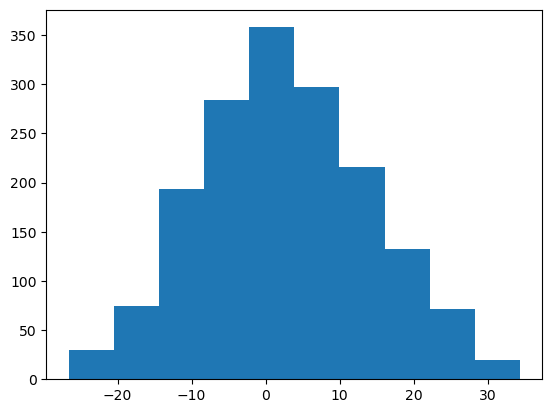

In [25]:
#Spread distribution
plt.hist(predictions[:,0])

(array([ 17.,  81., 230., 336., 388., 360., 180.,  54.,  26.,   5.]),
 array([39.70740891, 43.21909332, 46.73077393, 50.24245453, 53.75413895,
        57.26582336, 60.77750397, 64.28918457, 67.8008728 , 71.31255341,
        74.82423401]),
 <BarContainer object of 10 artists>)

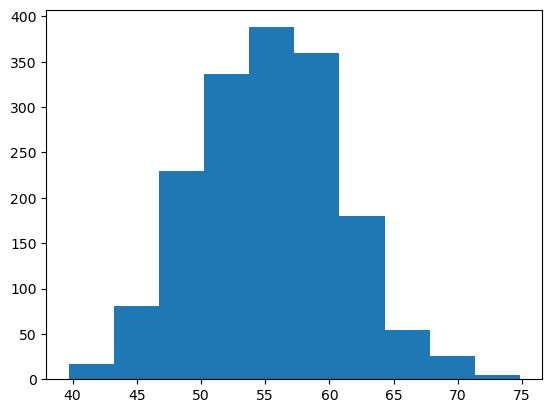

In [26]:
#Total points distribution
plt.hist(predictions[:,1])

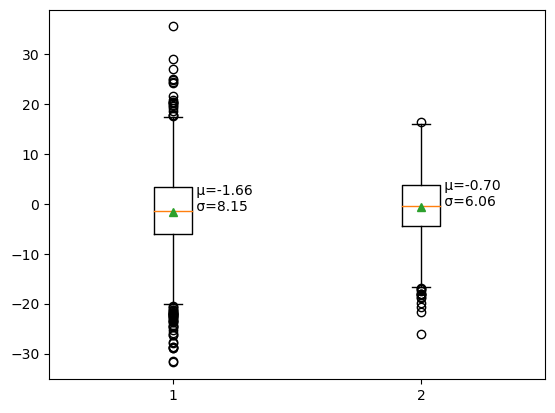

In [27]:
#creating boxplot
diff = predictions-y_test[:,:2]
diffmean = diff.mean(axis=0)
bestdiffstd = diff.std(axis=0)   
fig, ax = plt.subplots()
bp = ax.boxplot(diff,showmeans=True)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(diffmean[i], bestdiffstd[i])
    ax.annotate(text, xy=(x, y))
plt.show()

(Working with Home and Away Pts)

(Working with Actual Spread and Pts)

As we can observe from above, we obtain a more accurate machine learning model when using betting lines as the target variable.

Working on Actual Game data, might be correlated to the team statistics, it doesn't take into account the chaos and unpredictability that each game has.

Betting lines are created with the economic purpose of finding the mean of the distribution of possible outcomes, which means that they predict there is a 50% chance that something lower than the mean occurs and 50% chance something higher than the mean occurs. They also involve expectations on the team strength and performance, something that cannot be directly seen on actual game results but is seen on final season statistics.

Note: The following code allows you to save the model as a file.

In [28]:
model.save("CFBprediction.h5")

## Pairing System using Minimum Weight Matching Algorithm

Using teams locations extracted before, we run the Pairing Algorithm using Minimum Weight Matching and Networkx. Which does the following: Selects pairs of vertices where the sum of those edges is minimized. First we retrieve data from the database, then we use NetworkX package to create the Graph and do the pairings, which afterwards we simulate games using our model, add results to database, and finally update the graph to remove played matches. 

In [29]:
conn = sqlite3.connect("CollegeFootball.db")
distances = pd.read_sql_query("SELECT * FROM distances",conn)
conn.close()
distances

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,0.000000,18.768889,18.059167,20.645556,11.290556,11.266389,10.980278,14.000833,25.148056,19.765278,...,21.718333,20.450556,21.376944,18.996389,16.578333,15.363333,15.908333,19.993056,13.922500,2.934167
1,18.768889,0.000000,10.334722,6.569444,27.659722,27.704444,12.506944,10.238056,6.508333,11.017500,...,6.343056,5.205278,6.131667,32.907500,30.186667,6.253889,4.042500,2.715278,7.173333,18.486944
2,18.059167,10.334722,0.000000,7.064444,20.666111,22.140278,7.771944,4.552778,14.962778,2.671944,...,9.436944,7.641667,7.374722,35.676389,32.955556,4.376111,10.627778,10.523889,11.779722,19.784722
3,20.645556,6.569444,7.064444,0.000000,26.890000,27.649722,12.239722,9.020556,9.865833,6.243611,...,4.340000,2.544722,1.598333,37.889167,35.168333,6.050278,10.140556,5.426944,12.155278,22.007222
4,11.290556,27.659722,20.666111,26.890000,0.000000,1.684167,16.571944,18.985278,34.053333,22.713611,...,29.253611,27.458056,27.738333,22.165833,20.551389,22.686389,25.758889,28.898056,24.628611,14.070278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,15.363333,6.253889,4.376111,6.050278,22.686389,23.459167,8.083611,4.830833,12.638611,5.548889,...,8.145278,6.628056,7.132500,32.585278,29.856667,0.000000,6.535833,6.921389,7.766944,16.734167
122,15.908333,4.042500,10.627778,10.140556,25.758889,25.787222,10.596944,8.707222,10.226389,11.800556,...,9.882500,8.753333,9.701667,29.808056,27.079444,6.535833,0.000000,6.359722,4.155556,15.425833
123,19.993056,2.715278,10.523889,5.426944,28.898056,28.926389,13.736111,10.941667,6.153056,10.535833,...,4.085278,4.039722,4.988056,35.175278,32.446667,6.921389,6.359722,0.000000,9.524722,20.838056
124,13.922500,7.173333,11.779722,12.155278,24.628611,24.656667,9.873611,8.546667,13.357222,12.952500,...,12.521111,11.237778,12.186111,26.112500,23.383889,7.766944,4.155556,9.524722,0.000000,13.431389


In [30]:
# import networkx as nx

m_dist = np.round(np.array(distances),decimals=3)
L = []
for k in range(126):
    for j in range(126):
        if k>j: L.append((k,j,m_dist[k,j]))
        
CollegeGraph = nx.Graph()
CollegeGraph.add_weighted_edges_from(L)
curr_data = np.zeros(shape=(126,3),dtype=int)
curr_data[:,0] = np.arange(126)

for i in range(12):
    DataFunctions.Simulate(g=CollegeGraph,
                           i=i,c=curr_data,
                           y=2022,st_dev=bestdiffstd)

Round: 1
[(72, 73), (54, 10), (95, 84), (90, 103), (17, 64), (1, 43), (82, 38), (20, 32), (41, 6), (57, 115), (16, 111), (42, 63), (36, 83), (68, 124), (116, 76), (25, 62), (18, 56), (39, 60), (14, 101), (29, 53), (45, 49), (11, 94), (48, 121), (30, 88), (21, 0), (119, 120), (9, 102), (74, 100), (109, 65), (4, 5), (106, 28), (15, 93), (46, 47), (51, 61), (2, 105), (78, 79), (99, 114), (86, 92), (97, 98), (108, 13), (123, 50), (91, 27), (7, 52), (40, 58), (33, 89), (12, 112), (19, 44), (81, 80), (22, 125), (75, 104), (35, 34), (23, 8), (118, 117), (66, 113), (110, 85), (59, 77), (69, 87), (26, 55), (70, 37), (122, 71), (24, 67), (3, 96), (107, 31)]
63
Round: 2
[(21, 22), (66, 5), (44, 72), (6, 63), (9, 35), (1, 15), (13, 23), (88, 90), (83, 45), (85, 109), (31, 92), (74, 75), (69, 94), (46, 7), (81, 123), (18, 122), (20, 3), (98, 99), (117, 76), (62, 24), (105, 59), (106, 33), (39, 40), (14, 26), (91, 29), (16, 112), (54, 38), (68, 70), (115, 121), (61, 95), (78, 120), (93, 108), (32, 3

The last part of the code above, the function `Simulate` runs the pairings and simulate results for a single week. More detail can be seen `DataFunctions.py` file.

The rules of the pairing per round are the following:
1. Split all teams in groups based on their number of wins
2. From outside to inside groups, apply the minimum weight matching algorithm to pair teams with the same number of wins.
3. If there are any unpaired teams, add those teams to the next unpaired group. This generally ocurrs when groups have an odd number of teams or when a team has already played most of the teams in their group.<br>
After all teams are paired, we run the simulation using our machine learning model on all of them

The following code is an example on how the pairings where done on the function.

```python
matchings = []
gnum = 0
gcount = 0
while gcount < (i+1):
    g_group = g.subgraph(groups[gnum])
    matching_group = nx.algorithms.matching.min_weight_matching(g_group)
    s = set(groups[gnum]) - set(np.array(list(matching_group)).flatten())
    if len(s) > 0:
        for k in s:
            groups[gnum].remove(k)
            groups[(gnum+1)].append(k)
    matchings += matching_group
    gcount += 1
    
    if gcount >= (i+1):break
    
    gnum2 = i - gnum
    g_group = g.subgraph(groups[gnum2])
    matching_group = nx.algorithms.matching.min_weight_matching(g_group)
    s = set(groups[gnum2]) - set(np.array(list(matching_group)).flatten())
    if len(s) > 0:
        for k in s:
            groups[gnum2].remove(k)
            groups[(gnum2-1)].append(k)
    matchings += matching_group
    gcount += 1
    gnum += 1
```

Note: The code below allows us to remove the previously simulated games from our database.

In [ ]:
# import sqlite3
# conn = sqlite3.connect("CollegeFootball.db")
# cursor = conn.cursor()
# cursor.execute("DROP TABLE simul_games")
# conn.commit()
# conn.close()

## Simulated Results

First, let's look at the standings, which we can easily do by calling our show_standings function. First, we can view the standings at the midway point of the season, being after week 6, as well as the end of the season. 

In [2]:
DataFunctions.show_standings(week=6)

,Team,Wins,Losses
0,Georgia,6,0
1,Ohio State,6,0
2,UCLA,5,1
3,Michigan,5,1
4,Oregon State,5,1
...,...,...,...
121,Louisiana Monroe,1,5
122,Colorado,1,5
123,Indiana,1,5
124,Georgia Tech,0,6


In [3]:
DataFunctions.show_standings(week=12)

,Team,Wins,Losses
0,Georgia,11,1
1,UCLA,10,2
2,Ohio State,10,2
3,Michigan,10,2
4,Alabama,9,3
...,...,...,...
121,Louisiana Monroe,3,9
122,Florida International,3,9
123,Arkansas State,2,10
124,Colorado,1,11


Unfortunately, only the first five and last five rows of the table are displayed. However, we can fix this by calling 'print(df.to_string()' on our dataframe.

In [8]:
print(DataFunctions.show_standings(week=12).to_string())

                      Team  Wins  Losses
0                  Georgia    11       1
1                     UCLA    10       2
2               Ohio State    10       2
3                 Michigan    10       2
4                  Alabama     9       3
5             Oregon State     9       3
6                 Illinois     9       3
7                Tennessee     9       3
8                 Maryland     8       4
9                  Houston     8       4
10                     UCF     8       4
11                  Tulane     8       4
12                     LSU     8       4
13               Air Force     8       4
14              Texas Tech     8       4
15           Florida State     8       4
16                   Texas     8       4
17          North Carolina     8       4
18              Notre Dame     8       4
19                  Oregon     8       4
20               Minnesota     8       4
21                  Purdue     8       4
22                    Army     8       4
23          UT S

Unsurprisingly, we have that Georgia finished with the best overall record at 11-1, as they were undoubtedly the top team in the actual 2022 season going 15-0 and winning the national championship. Close behind we have Ohio State and Michigan State, both of which were also ranked in the top four of the final top 25 rankings of the 2022 season, thus qualifying for the playoffs. We do notice that TCU, who were ranked #2 at the end of the season, finished with a record of just 7-5. This could be in part due to some randomness in the simulation, as well as the fact that TCU was widely considered to be an underdog at the start of the season and defied the betting lines in some sense. Also, many of their wins were very tight games, so their season statistics would not necessarily be as dominant as those of the other top teams such as Georgia. However, overall most of the teams that finished at the top are those which performed well and were ranked near the top in the actual 2022 season, which is a sign that are model performs pretty well.

To get a closer look at how specific teams in particular performed, we can call the 'team_results' function on any one team. Let's start by looking at Georgia's results. 

In [9]:
DataFunctions.team_results('Georgia')

,Week,Home Team,Home Points,Away Team,Away Points
0,1,Georgia (1-0),38,Clemson (0-1),14
1,2,Georgia State (1-1),9,Georgia (2-0),37
2,3,Alabama (2-1),19,Georgia (3-0),35
3,4,Georgia (4-0),41,Wake Forest (3-1),20
4,5,Florida State (4-1),27,Georgia (5-0),36
5,6,Georgia (6-0),35,UCLA (5-1),31
6,7,Georgia (7-0),40,Ohio State (6-1),20
7,8,Tennessee (6-2),32,Georgia (8-0),35
8,9,Georgia (9-0),34,Illinois (7-2),10
9,10,Michigan (8-2),28,Georgia (9-1),22


From this we can see that Georgia's only loss came against Michigan in Week 10, and besides that they were perfect. Furthermore, by nature of this pairing system, they had to face most of the other teams that finished near the top of the standings, yet we can see that by week 10 they were facing UAB who only had a record of 7-3 going into the game. While this may seem surprising given that Georgia had a record of 9-1, notice that Georgia had already played top teams such as Michigan, UCLA, and Ohio State at that point, so they were still facing teams with the best record among those teams which they hadn't already played.

We can also take a look who UCLA faced, as they also finished quite high with a record of 10-2.

In [10]:
DataFunctions.team_results('UCLA')

,Week,Home Team,Home Points,Away Team,Away Points
0,1,UCLA (1-0),28,Fresno State (0-1),21
1,2,USC (1-1),30,UCLA (2-0),34
2,3,UCLA (3-0),35,San José State (2-1),32
3,4,Air Force (3-1),17,UCLA (4-0),33
4,5,UCLA (5-0),32,Utah (4-1),28
5,6,Georgia (6-0),35,UCLA (5-1),31
6,7,Oregon State (5-2),27,UCLA (6-1),36
7,8,UCLA (7-1),36,Alabama (6-2),31
8,9,Ohio State (7-2),32,UCLA (8-1),38
9,10,UCLA (9-1),31,Texas (7-3),27


Now we can see that the only teams UCLA lost to were Georgia and Michigan, both in relatively close games, though they also won a number of one possession games. Furthermore, as expected UCLA faced many of the teams at the top of the standings. However, so far we have not seen the effect geographic proximity has had with the new pairing system, which is what we will do in the next section. 

## Graphical Visualizations of Results

To observe the effects of teams' locations on who they get paired with, we can use the 'plot_teams_games' function on any one specific team. Let's begin by plotting UCLA's games. 

In [12]:
DataFunctions.plot_teams_games('UCLA')

To create this plot, we constructed a plotly graph object which we could customize with various traces corresponding to the different features of the plot. Unfortunately, there did not seem to be an easy way to create it with plotly express, so while this allowed for much more customization, it was also way longer and more difficult to code. Anyways, moving on to the plot itself, we have a gold star in the location of the team we are highlighting, so in our case UCLA, and then edges going to points at the locations of all their opponents throughout the entire season. Each point is color coded red or blue depending if it was a home game or away game for UCLA, and is labeled with the driving distance between the two teams. Finally, if we hover over any of the points, it shows the teams that played (one of them being UCLA of course), the final score, and the week the game occurred.

Now it appears that perhaps the pairing system did not work well, given that UCLA or their opponents had to travel across most of the country for some of the games. However, by hovering over the various games we see that the first couple games UCLA played teams such as Fresno State, USC, and Utah, which are all relatively close to UCLA. However, we must remember that the first criteria for pairing teams is their team record, and UCLA jumped out to a red hot 5-0 start. At this point, there will always be more teams with an even record than teams that either win or lose basically all its games, so the more UCLA moved up to the top of the standings, the fewer options of teams there were for them to face. That's why by the later weeks in the season, UCLA is playing teams like Georgia and Michigan simply because those are the only other teams with as good a record as them. 

On top of this, there are way more schools in the eastern half of the country than the western half, so we can look at the same plot for a team such as Georgia, and wes see that besides the game against UCLA, all of the other top teams which Georgia faced happened to fall in the eastern part of the country. So despite playing many of the same teams as UCLA at the top of the standings, they hardly had to travel as much in comparison.

In [15]:
DataFunctions.plot_teams_games('Georgia')

Finally to emphasize this point, if we pick a team in the eastern part of the country with an even record, say NC State who finished 6-6, we see that because of the variety of options for opponents each week and the density in teams close by, all but three of their opponents were within a six hour drive of them.

In [16]:
DataFunctions.plot_teams_games('NC State')

## Conclusion and Further Improvements

From the results and visualizations of the simulation, we see that the pairing system does its job in pairing the teams with the best record with the best, and trying to pair teams within close proximity of each other when possible. However after the first few weeks, the pairings of the teams with the best and worst records will mostly just be based on team record and the geographic location will have less of an effect. On the other hand, as a fan this creates the most exciting games by matching the top teams against each other, and if this system was implemented we should be able to get a much better sense of who the best teams are by the end of the season. Of course the difficulty is that unlike the current pairing system, teams would not know their next opponents until less than a week before the game, which would make it harder to prepare and plan for it logistically. 

When loking at results of the model, while it seems the model performed fairly well overall, there are still potential biases that are important to keep in mind. Since all the predictor variables were statistics for each team averaged over an entire season, teams could have same good games where they beat up on really bad teams which inflate their stats in a sense, or some bad games where they take a beating and deflate their stats disproportionally such that perhaps a model that used a collection of individual game statistics instead of season long averaged statistics would fare better. Also, under the current college football conference alignment there are always certain conferences which seem to be stronger than others, so the strength of schedule of two D1 FBS teams could be very different year after year. Thus two teams could have similar overall statistics, but their strength of schedules were so different that it's hard to compare the two in this manner. Finally the randomness factor can always lead to some unexpected results, and we used the same standard deviation and distribution to adjust the predicted scores of the model for each game, wheras in reality there might be some games where it would seem more or less likely for the results to be more skewed one way or the other. However, ultimately one of the beauty of sports is that anyone can win on any given day and you're never going to know what you're going to get, so if we see a surprising result here and there we should not jump to the conclusion that are model is bad or our simulation is unrealistic. 

Finally, if we wanted to further implement this pairing system, one current drawback is that there is no randomness in the creation of the pairings, rather if the same set of teams have the same records at the same step, we will always have the same pairings. So for example, the week 1 matchups will always be the same year after year, and since many of these games might be consistently lopsided, there could be lots of repetition in the first couple weeks of the season every time this system is used. Thus, one potential improvement could be instead of just taking the most optimal pairings, randomly draw from one of the best pairing options. One way to do this could be assinging a 'score' for each set of pairings based on the geographical distances betwen teams, and either drawing from one of the top scores, or take all the scores within a certain range from the best one and draw randomly between those. However, this would require more work to develop such a system, as we may have to use different algorithms to do so, and we know that we cannot just iterate through every possible set of pairings assigning each one a score, as this would require way too much computational power. Also this pairing system could be tested with other sports, for example it would be interesting to see how it may affect a college basketball season where there are more D1 teams and many more games played throughout the course of the season. However we shall save this for a future project, not this one. 